In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange, sample
from math import log2, sqrt,ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_digits
import time

In [28]:
bg = 26

In [3]:
def gini_index_numerical(above_split, below_split, attribute):
    #UPDATING NOW INPUTS ARE DATAFRAMES
    total_above = len(above_split)
    total_below = len(below_split)
    total = total_above + total_below
    #for each class calculate the individual index
    above_index = 0
    below_index = 0
    #probability point is above
    #TODO OPTIMIZE
    labels = ['0','1']
    above_count = above_split['class'].value_counts()
    below_count = below_split['class'].value_counts()
    for i in range(0,len(labels)):
        #check for empty frames
        try:
            p_above = 0 if above_split.empty else above_count[i] / total_above
        except KeyError:
            p_above = 0
        try:
            p_below = 0 if below_split.empty else below_count[i] / total_below
        except KeyError:
            p_below = 0
        above_index += (p_above * p_above)
        below_index += (p_below * p_below)
    above_index = 1 - above_index
    below_index = 1 - below_index
    return (above_index * (total_above / total)) + (below_index * (total_below / total))

gini_index_numerical takes in two n-d numpy arrays where n represents the number of potential classes. The above_split array represents all of the points located numerically above the split point and the below_split array represents the points with a lesser value.

In [4]:
def entropy_calculation(splits, labels, total_in_set):
    #calculate the total entropy by calculating the probabilities
    if not splits:
        return 2
    entropy_before_split = 0
    for label in range(0, len(labels)):
        try:
            entropy_before_split += labels[label] / total_in_set
        except KeyError:
            entropy_before_split = entropy_before_split
    entropy = 0
    for split in splits:
        #for each split calculate the entropy for the given label set
        split_entropy = 0
        total_in_split = len(split)
        label_count = split['class'].value_counts()
        for label in range(0,len(labels)):
            #calculating entropy
            #need to get the values for each label within the split
            #i.e. if split A has 15 values, 4 are class 0: 5 are class 1 and 6 are class 2
            #class 0 would have 4/15 * log2(4/15)
            try:
                label_dist = 0 if split.empty else label_count[label] / total_in_split
            except KeyError:
                label_dist = 0
            split_entropy = split_entropy if label_dist == 0 else (split_entropy + (label_dist * log2(label_dist)))
            #split_entropy += (label_dist * log2(label_dist))
        entropy += split_entropy
    entropy = (-1)*(entropy)
    return entropy
        

In [5]:
def gini_index_calculation(splits, labels, total_in_set):
    #calculate for each potential class
    if not splits:
        return 2
    g_index = 0
    for split in splits:
        split_index = 0
        label_count = split['class'].value_counts()
        total_in_split = len(split)
        #for label in labels:
        for label in range(0,len(labels)):
            try:
                p_split = 0 if split.empty else (label_count[label] / total_in_split)
            except (KeyError, IndexError):
                p_split = 0
            split_index += (p_split * p_split)
        split_index = 1-split_index
        g_index += (split_index * (total_in_split / total_in_set))
    return g_index    

In [6]:
def misclassification_calculation(splits, labels, total_in_set):
    #for each split
    if not splits:
        return 2
    max_classification = 0
    for split in splits:
        #find the class which maximizes the fraction of correctly classified points
        label_count = split['class'].value_counts()
        total_in_split = len(split)
        for label in range(0,len(labels)):
            #if label exists within row
            try:
                classification_ind = 0 if split.empty else (label_count[label] / total_in_split)
            except (KeyError, IndexError):
                classification_ind = 0
            if classification_ind > max_classification:
                max_classification = classification_ind
    return (1 - max_classification)


The gini_index_multiclass function takes in the splits, the attribute the set was split on, and the potential labels. The potential features should be defined as [0,1,...n-1] where n is the total number of features within the set. Possible feature values could depend on dataset (is pixel on or off, position of pixel, 

In [7]:
class Node:
    def __init__(self, splitting_point, split_values, split_feature):
        self.split_values = split_values
        self.split_feature = split_feature
        #self.splitting_attribute = splitting_attribute
        self.splitting_point = splitting_point
        #TODO change to k for k classes?
        if split_values == 0:
            #self.children = np.zeros(2)
            self.children = [0 for i in range(0,2)]
        else:
            #self.children = np.zeros(len(split_values))
            self.children = [0 for i in range(0,len(split_values))]
        self.children_split_length = np.zeros(len(self.children))
    
    def new_child_node(self, child_index, child, split_length):
        #print(child_index, child)
        self.children[child_index] = child
        self.children_split_length[child_index] = split_length
        
    def __str__(self):
        a = f"splitting_point {self.splitting_point} , split_feature {self.split_feature}\n"
        for idx, child in enumerate(self.children):
            a += f"child {idx}: {child}"
        return a
    
    def predict(self, point):
        val = point[self.split_feature]
        #child_index = self.children.index(val)
        
        #print(val, self.splitting_point, "retrurning -> ")
        if self.split_values == 0:
            if val >= self.splitting_point:
                #print(self.children[0])
                return self.children[0]
            else:
                #print(self.children[1])
                return self.children[1]
        else:
            #UPDATE THIS FUNCTION HOW TO FOLLOW PATH WHEN NON NUMERICAL?
            if isinstance(point[self.split_feature],str):
                splitting_val = point[self.split_feature].split()
            else:
                splitting_val = [point[self.split_feature]]
            #GET INDEX OF THE VALUE IN SPLIT_VALUES WHIHC MATCHES INCOMING POINT?
            #'?' represents an unknown value, how to deal with?
            #perhaps follow split with most number of attributes?
            if splitting_val[0] == "?":
                #unknown follow feature attribute with most values?
                #return index of max split value
                child_index = np.argmax(self.children_split_length)
            else:
                child_index = self.split_values.index(splitting_val[0])
            return self.children[child_index]

The Node class represents each node within the tree. The splitting attribute and point determines the axis and value the node splits on. The above and below values represent the next node or label based on the splitting point.

In [8]:
def split_continuous(value, attribute, examples):
    #split where item in row > or < value
    above_values = examples.loc[examples[attribute] >= value]
    below_values = examples.loc[examples[attribute] < value]
    return [above_values, below_values]
    

In [9]:
def split_discrete(feature_name, feature_values, examples):
    #split dataset based on all possible values
    #TODO make this dynamically adjustable for when |features| > 2!
    #CHOOSE M RANDOM FEATURE VALUES
    # if len(feature_values) > 2:
    #     feature_values = get_random_feature_values(
    splits = []
    for value in feature_values:
        #value = value.rjust(len(value)+1)
        subset = examples.loc[examples[feature_name] == value]
        splits.append(subset)
    return splits                                   

In [10]:
def find_best_split(examples, features, calculate_purity,M):
    #given a dataframe -> examples find the best splitting value within based
    #on the given purity calculation
    #for row in examples
        #for attribute in row
            #value = row[attribute]
            #split = split(value, examples)
            #purity = calculate_purity(split)
            #if purity better than best purity is best
    #TODO OPTIMIZE THIS
    best_purity = 2
    best_node = None
    best_splits = []
    #Randomly Select M features from the feature list and find best split from those!
    r_features = dict(sample(features.items(),M))
    
    for index, row in examples.iterrows():
        #loop through all features determining which are continous and which are discrete
        #discrete -> pixel on / off or values such as couldy/rainy/windy
        for feature_name, values in r_features.items():
            
            if(row[feature_name] == "?"):
                print("UNKNOWN")
            if(values == 0):
                #continous split based on current value in the row
                try:
                    splits = split_continuous(row[feature_name],feature_name,examples)
                except (IndexError,KeyError):
                    splits = []
            else:
                #split based on 
                splits = split_discrete(feature_name, values, examples)           
            #split dataframe into 2 dataframes
            #splits = split(row[val], val, examples)
            #purity = calculate_purity(above_split, below_split, val)
            purity = calculate_purity(splits, examples['class'].value_counts(), len(examples))
            if purity < best_purity:
                best_purity = purity
                #create new node based on best attribute and value
                best_node = Node(row[feature_name], values, feature_name)
                best_splits = splits
    return best_node, best_splits
        

In [11]:
def most_common_class(examples):
    classes = examples['class'].value_counts()
    return classes.idxmax()

In [12]:
def number_of_classes_in_samples(examples):
        return len(examples['class'].value_counts())

In [13]:
def learn_tree(examples, features, parent_examples, depth, max_depth, calculate_purity,M):
    #work with ending conditions, if no more examples left then return most common class in parent examples
    if examples.empty or (number_of_classes_in_samples == 0):
        return most_common_class(parent_examples)
    elif (number_of_classes_in_samples(examples) == 1) or (depth >= max_depth):
        return most_common_class(examples)
    else:
        #find the best split possible within the current split points
        root_node, splits = find_best_split(examples, features, calculate_purity,M)
        if(root_node is None):
            #print("ROOT NODE IS NULL RETURNING MOST COMMON CLASS WITHIN EXAMPLES")
            root_node = learn_tree(pd.DataFrame(),features,examples,depth-1,max_depth,calculate_purity,M)
            #print(examples)
            #print("splits---",splits
        else:
            for i in range(0,len(splits)):
                #above and below calculations
                #split should consist of a subset of examples
                #print("new node creation ", len(splits[i]), depth)
                new_node = learn_tree(splits[i],features, examples,depth+1,max_depth, calculate_purity,M)
                #IF NODE IS NONE? RETURN 
                root_node.new_child_node(i,new_node, len(splits[i]))
        return root_node

In [14]:
def tree_prediction(point, root_node):
    if not isinstance(root_node,Node):
        return root_node
    prediction = root_node.predict(point)
    while isinstance(prediction, Node):
        prediction = prediction.predict(point)
    return prediction

In [15]:
def get_subset(data_frame, subset_length):
    #randomly sample rows from the dataframe up to length n
    #where n is the specified subset length
    subset = data_frame.sample(n=subset_length, random_state=bg)    
    return subset

In [16]:
def random_forest(data_frame, features, subset_length, max_depth, num_of_trees, purity_calculation,M):
    trees = []
    for i in range(0, num_of_trees):
        #generate a random subsample
        subset = get_subset(data_frame, subset_length)
        #create the tree and append to list
        tree = learn_tree(subset, features, None, 0, max_depth, purity_calculation,M)
        trees.append(tree)
    return trees

In [17]:
def predict_data_with_trees(testing_data, trees, num_of_trees):
    predicted_labels = []
    for index, row in testing_data.iterrows():
        predictions = np.zeros(num_of_trees)
        for i in range(0,num_of_trees):
            #casting to int because bincount does not like floating point
            #print(f"looking at tree {trees[i]}")
            #print(f"NEW ELEMENT: {row}")
            predictions[i] = tree_prediction(row, trees[i])
            #print(f"result {predictions[i]}")
        #select maximum class, voting method
        #print("done with predictions")
        most_voted_class = np.bincount(predictions.astype(np.int64)).argmax()
        predicted_labels.append(most_voted_class)
    return predicted_labels

In [43]:
def score(data, predictions):
    i, c, t = 0,0,0
    for ind, val in data['class'].items():
        if predictions[i] == val:
            c+=1
        i+=1
        t+=1
    return c, t , c/t*100

In [18]:
test_data = {'id': [1,2,3,4,5,6,7,8,9,10], '0': [1,12,4.3,6,14,2,9,14,5,4],'1':[4.5,7,1,3,4.8,15,17,7,1.9,10],'class':[0,1,0,0,1,0,1,1,0,0]}

In [19]:
df = pd.DataFrame(data=test_data)

In [22]:
tree_nums = [10, 50, 150]
max_depth = 4

In [23]:
testing = {'id': [1,2,3], '0': [1,19,11],'1':[4,12,11],'class':[0,1,1]}
tdf = pd.DataFrame(data=testing)
subset_length = sqrt(len(testing))
predictions = []
for num_of_trees in tree_nums:
    trained_trees = random_forest(df,features,subset_length,max_depth,num_of_trees,entropy_calculation)
    for root_node in trained_trees:
        print(root_node)
    predictions = predict_data_with_trees(tdf,trained_trees,num_of_trees)
print(predictions)

NameError: name 'features' is not defined

In [86]:
features = {"sepal length":0,"sepal width":0,"petal length":0,"petal width":0}
f_names = ["sepal length","sepal width","petal length","petal width","class"]
newdf = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",names=f_names)
labelEnc = LabelEncoder()
labelEnc.fit(newdf['class'])
newdf['class'] = labelEnc.transform(newdf['class'])
newdf.tail()

,sepal length,sepal width,petal length,petal width,class
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [87]:
labels = newdf['class'].value_counts()
labels
tree_nums = [10, 50, 150]
max_depth =6

length_of_data = len(newdf)
train_ratio = 0.7
length_of_train = length_of_data * train_ratio
train, test = train_test_split(newdf, test_size = 0.3, random_state = 43, shuffle=True)
subset_length = ceil(sqrt(len(train)))
calculation_options = [gini_index_calculation, entropy_calculation, misclassification_calculation]
len_of_features = len(features)
M = [i for i in range(2,ceil(log2(len_of_features+1))) if i % 2 == 0]

In [88]:
print(len(train), len(test), subset_length, max_depth, tree_nums)

105 45 11 6 [10, 50, 150]


In [92]:
for rand_feature_len in M:
    iris_predictions, iris_correct, iris_acc = [], [], []
    for idx, calculation in enumerate(calculation_options):
        print("Results for: %s" % calculation_options[idx].__name__)
        p_, c_, a_ = [], [], []
        for num_of_trees in tree_nums:            
            st_ = time.time()
            trained_trees = random_forest(train, features, subset_length, max_depth, num_of_trees, calculation,rand_feature_len)
            et_ = round((time.time() - st_), 3)
            predictions = predict_data_with_trees(test, trained_trees, num_of_trees)
            correct, total, accuracy = score(test, predictions)
            p_.append(predictions)
            c_.append(correct)
            a_.append(accuracy)
            print(f"# of Correct classifications: {correct} | total: {total} | accuracy: {round(accuracy, 3)} | training time: {et_} sec")
        iris_acc.append(a_)
        iris_correct.append(c_)
        iris_predictions.append(p_)

Results for: gini_index_calculation
# of Correct classifications: 31 | total: 45 | accuracy: 68.889 | training time: 1.179 sec
# of Correct classifications: 32 | total: 45 | accuracy: 71.111 | training time: 5.429 sec
# of Correct classifications: 32 | total: 45 | accuracy: 71.111 | training time: 16.432 sec
Results for: entropy_calculation
# of Correct classifications: 32 | total: 45 | accuracy: 71.111 | training time: 1.326 sec
# of Correct classifications: 32 | total: 45 | accuracy: 71.111 | training time: 5.727 sec
# of Correct classifications: 32 | total: 45 | accuracy: 71.111 | training time: 18.786 sec
Results for: misclassification_calculation
# of Correct classifications: 31 | total: 45 | accuracy: 68.889 | training time: 1.914 sec
# of Correct classifications: 34 | total: 45 | accuracy: 75.556 | training time: 10.069 sec
# of Correct classifications: 33 | total: 45 | accuracy: 73.333 | training time: 34.11 sec


In [93]:
print(iris_correct)

[[31, 32, 32], [32, 32, 32], [31, 34, 33]]


Text(0.5, 1.0, 'Iris Data Set Accuracy')

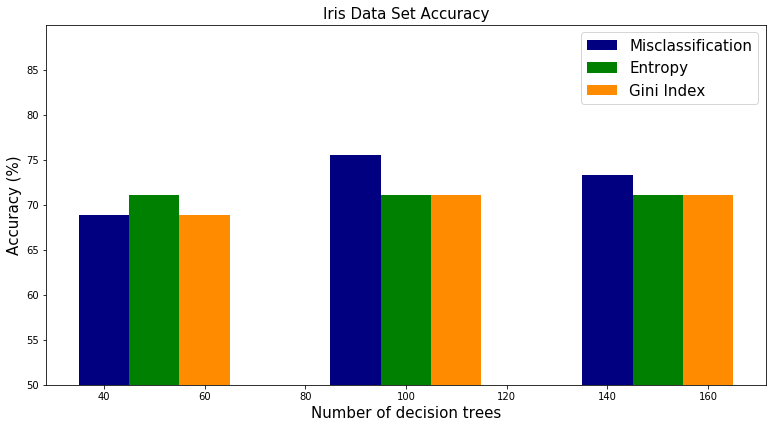

In [94]:
num_of_trees = [50,100,150]
Iris_Gini = np.array(iris_correct[0]) / 45
Iris_Entropy = np.array(iris_correct[1]) / 45
Iris_Misclassification = np.array(iris_correct[2]) / 45

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
num_of_trees = np.array(num_of_trees)
ax.bar(num_of_trees-10, Iris_Misclassification*100, color = 'navy', width = 10)
ax.bar(num_of_trees, Iris_Entropy*100, color='g',width=10)
ax.bar(num_of_trees+10,Iris_Gini*100,color='darkorange',width=10)
#ax.set_xticks()
ax.set_yticks(np.arange(50,90, 5))
ax.set_ylabel("Accuracy (%)", fontsize = 15)
ax.set_xlabel("Number of decision trees", fontsize = 15)
ax.legend(['Misclassification','Entropy','Gini Index'], fontsize = 15)
plt.ylim([50,90])
plt.title("Iris Data Set Accuracy", fontsize = 15)

#plt.savefig('out/acc_iris.jpg')

In [95]:
f_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class']
adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names = f_names)
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [96]:
features = {'age':0,
            'workclass':["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked"],
            'fnlwgt':0,
            'education':['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
            'education-num':0,
            'marital-status':['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
            'occupation':['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
            'relationship':['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
            'race':['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
            'sex':['Female', 'Male'],
            'capital-gain':0,
            'capital-loss':0,
            'hours-per-week':0,
            'native-country':['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 
                                'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']}
labelEnc.fit(adult['class'])
adult['class'] = labelEnc.transform(adult['class'])
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [ ]:
max_depth = 10
length_of_data = len(adult)
train, test = train_test_split(adult, test_size = 0.3, random_state = 42, shuffle=True)
subset_length = ceil(sqrt(len(train)))
print("Subset Length: %d" % subset_length)
tree_nums = [50,100,150]
adult_predictions, adult_correct, adult_acc = [], [], []
for idx, calculation in enumerate(calculation_options):
    print("Results for: %s" % calculation_options[idx].__name__)
    p_, c_, a_ = [], [], []
    for num_of_trees in tree_nums:        
        st_ = time.time()
        trained_trees = random_forest(train, features, subset_length, max_depth, num_of_trees, calculation,rand_feature_len)
        et_ = round((time.time() - st_), 3)
        predictions = predict_data_with_trees(test, trained_trees, num_of_trees)
        correct, total, accuracy = score(test, predictions)
        p_.append(predictions)
        c_.append(correct)
        a_.append(accuracy)
        print(f"# of Correct classifications: {correct} | total: {total} | accuracy: {round(accuracy, 3)} | training time: {et_} sec")
    adult_acc.append(a_)
    adult_correct.append(c_)
    adult_predictions.append(p_)

In [80]:
print(adult_correct)

[[7455, 7455, 7455], [1188, 1188, 1188], [1188, 1188, 1188], [1183, 1180, 1180]]


Text(0.5, 1.0, 'Iris Data Set Accuracy')

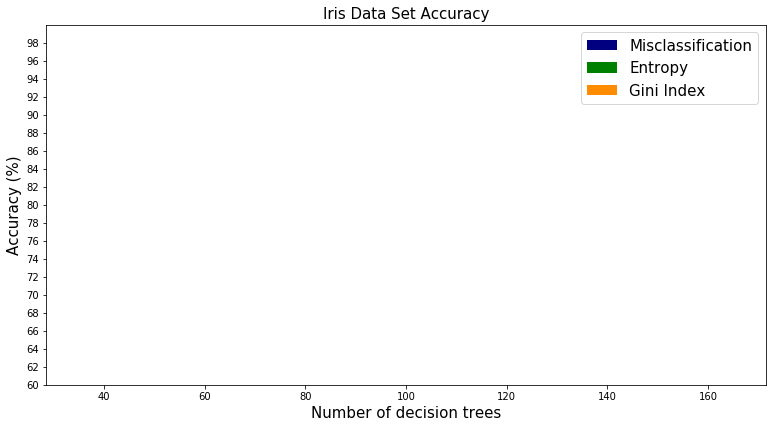

In [81]:
num_of_trees = [50,100,150]
adult_Gini = np.array(adult_correct[0]) / len(test) 
adult_Entropy = np.array(adult_correct[1]) / len(test) 
adult_Misclassification = np.array(adult_correct[2]) / len(test) 

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
num_of_trees = np.array(num_of_trees)
ax.bar(num_of_trees-10, adult_Misclassification*100, color = 'navy', width = 10)
ax.bar(num_of_trees, adult_Entropy*100, color='g',width=10)
ax.bar(num_of_trees+10,adult_Gini*100,color='darkorange',width=10)
#ax.set_xticks()
ax.set_yticks(np.arange(60,100, 2))
ax.set_ylabel("Accuracy (%)", fontsize = 15)
ax.set_xlabel("Number of decision trees", fontsize = 15)
ax.legend(['Misclassification','Entropy','Gini Index'], fontsize = 15)
plt.ylim([60,100])
plt.title("Adult Data Set Accuracy", fontsize = 15)

#plt.savefig('out/acc_adult.jpg')

In [98]:
#blobs dataset
f_names = ["id","x","y","class"]
blobs = pd.read_csv('blobs.csv')
blobs.head()

,Unnamed: 0,0,1,class
0,0,1.804935,1.584168,0
1,1,5.182373,2.871899,1
2,2,2.146936,1.542081,0
3,3,5.055332,3.235553,1
4,4,5.159758,3.095634,1


In [100]:
features = {"0":0, "1":0}
max_depth = 10
tree_nums = [10,50,150]
train,test = train_test_split(blobs, test_size=0.3,random_state = 42, shuffle=True)
subset_length = ceil(sqrt(len(train)))
calculation_options = [gini_index_calculation, entropy_calculation, misclassification_calculation]

In [101]:
blobs_predictions, blobs_correct, blobs_acc = [], [], []
for idx, calculation in enumerate(calculation_options):
    print("Results for: %s" % calculation_options[idx].__name__)
    p_, c_, a_ = [], [], []
    for num_of_trees in tree_nums:        
        st_ = time.time()
        trained_trees = random_forest(train, features, subset_length, max_depth, num_of_trees, calculation,rand_feature_len)
        et_ = round((time.time() - st_), 3)
        predictions = predict_data_with_trees(test, trained_trees, num_of_trees)
        correct, total, accuracy = score(test, predictions)
        p_.append(predictions)
        c_.append(correct)
        a_.append(accuracy)
        print(f"# of Correct classifications: {correct} | total: {total} | accuracy: {round(accuracy, 3)} | training time: {et_} sec")
    blobs_acc.append(a_)
    blobs_correct.append(c_)
    blobs_predictions.append(p_)

Results for: gini_index_calculation
# of Correct classifications: 1188 | total: 1200 | accuracy: 99.0 | training time: 3.66 sec
# of Correct classifications: 1188 | total: 1200 | accuracy: 99.0 | training time: 15.243 sec
# of Correct classifications: 1188 | total: 1200 | accuracy: 99.0 | training time: 44.988 sec
Results for: entropy_calculation
# of Correct classifications: 1188 | total: 1200 | accuracy: 99.0 | training time: 3.415 sec
# of Correct classifications: 1188 | total: 1200 | accuracy: 99.0 | training time: 15.806 sec
# of Correct classifications: 1188 | total: 1200 | accuracy: 99.0 | training time: 46.159 sec
Results for: misclassification_calculation
# of Correct classifications: 1176 | total: 1200 | accuracy: 98.0 | training time: 10.869 sec
# of Correct classifications: 1182 | total: 1200 | accuracy: 98.5 | training time: 40.269 sec
# of Correct classifications: 1180 | total: 1200 | accuracy: 98.333 | training time: 122.883 sec


In [112]:
print(blobs_acc[2])

[98.0, 98.5, 98.33333333333333]


Text(0.5, 1.0, 'Blobs Data Set Accuracy')

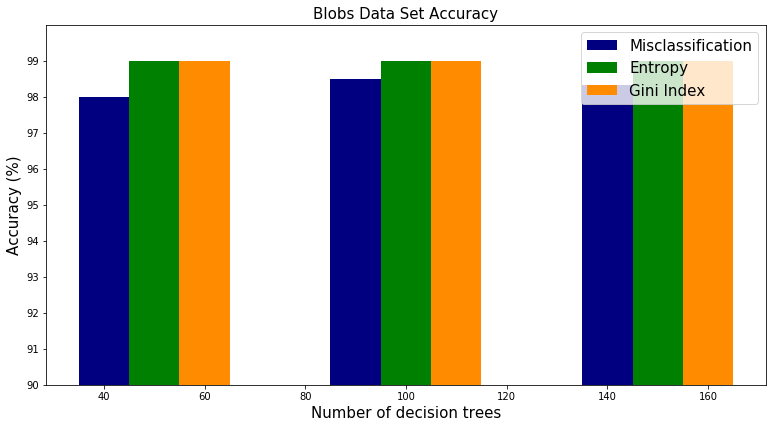

In [113]:
num_of_trees = [50,100,150]
blobs_Gini = np.array(blobs_acc[0])
blobs_Entropy = np.array(blobs_acc[1])
blobs_Misclassification = np.array(blobs_acc[2])

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
num_of_trees = np.array(num_of_trees)
ax.bar(num_of_trees-10, blobs_Misclassification, color = 'navy', width = 10)
ax.bar(num_of_trees, blobs_Entropy, color='g',width=10)
ax.bar(num_of_trees+10,blobs_Gini,color='darkorange',width=10)
#ax.set_xticks()
ax.set_yticks(np.arange(90,100, 1))
ax.set_ylabel("Accuracy (%)", fontsize = 15)
ax.set_xlabel("Number of decision trees", fontsize = 15)
ax.legend(['Misclassification','Entropy','Gini Index'], fontsize = 15)
plt.ylim([90,100])
plt.title("Blobs Data Set Accuracy", fontsize = 15)

#plt.savefig('out/acc_blobs.jpg')

In [114]:
#spirals dataset
f_names = ["id","x","y","class"]
spirals = pd.read_csv('spirals.csv')
spirals.head()

,Unnamed: 0,x,y,class
0,0,-0.564488,0.154728,0
1,1,0.394181,0.165268,0
2,2,-0.647047,-0.311047,0
3,3,-0.348048,-0.004684,1
4,4,0.250432,0.183623,0


In [115]:
features = {"x":0,"y":0}
max_depth = 10
tree_nums = [10,50,150]
train,test = train_test_split(spirals, test_size=0.3,random_state = 42, shuffle=True)
subset_length = ceil(sqrt(len(train)))
calculation_options = [gini_index_calculation, entropy_calculation, misclassification_calculation]

In [117]:
spirals_predictions, spirals_correct, spirals_acc = [], [], []
for idx, calculation in enumerate(calculation_options):
    p_, c_, a_ = [], [], []
    print("Results for: %s" % calculation_options[idx].__name__)
    for num_of_trees in tree_nums:
        st_ = time.time()
        trained_trees = random_forest(train, features, subset_length, max_depth, num_of_trees, calculation,rand_feature_len)
        et_ = round((time.time() - st_), 3)
        predictions = predict_data_with_trees(test, trained_trees, num_of_trees)
        correct, total, accuracy = score(test, predictions)
        p_.append(predictions)
        c_.append(correct)
        a_.append(accuracy)
        print(f"# of Correct classifications: {correct} | total: {total} | accuracy: {round(accuracy, 3)} | training time: {et_} sec")
    spirals_acc.append(a_)
    spirals_correct.append(c_)
    spirals_predictions.append(p_)

Results for: gini_index_calculation
# of Correct classifications: 180 | total: 300 | accuracy: 60.0 | training time: 6.389 sec
# of Correct classifications: 180 | total: 300 | accuracy: 60.0 | training time: 32.344 sec
# of Correct classifications: 180 | total: 300 | accuracy: 60.0 | training time: 106.724 sec
Results for: entropy_calculation
# of Correct classifications: 157 | total: 300 | accuracy: 52.333 | training time: 15.862 sec
# of Correct classifications: 157 | total: 300 | accuracy: 52.333 | training time: 78.934 sec
# of Correct classifications: 157 | total: 300 | accuracy: 52.333 | training time: 231.768 sec
Results for: misclassification_calculation
# of Correct classifications: 146 | total: 300 | accuracy: 48.667 | training time: 12.981 sec
# of Correct classifications: 146 | total: 300 | accuracy: 48.667 | training time: 67.441 sec
# of Correct classifications: 146 | total: 300 | accuracy: 48.667 | training time: 200.287 sec


Text(0.5, 1.0, 'Spiral Data Set Accuracy')

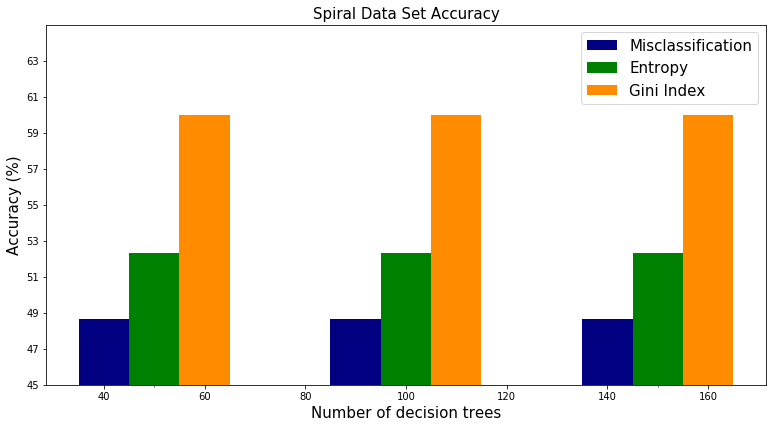

In [119]:
num_of_trees = [50,100,150]
spirals_Gini = np.array(spirals_acc[0])
spirals_Entropy = np.array(spirals_acc[1])
spirals_Misclassification = np.array(spirals_acc[2])

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
num_of_trees = np.array(num_of_trees)
ax.bar(num_of_trees-10, spirals_Misclassification, color = 'navy', width = 10)
ax.bar(num_of_trees, spirals_Entropy, color='g',width=10)
ax.bar(num_of_trees+10,spirals_Gini,color='darkorange',width=10)
ax.set_xticks(num_of_trees, ['10', '50', '100'])
ax.set_yticks(np.arange(45,65, 2))
ax.set_ylabel("Accuracy (%)", fontsize = 15)
ax.set_xlabel("Number of decision trees", fontsize = 15)
ax.legend(['Misclassification','Entropy','Gini Index'], fontsize = 15)
plt.ylim([45,65])
plt.title("Spiral Data Set Accuracy", fontsize = 15)

#plt.savefig('out/spirals.jpg')

In [123]:
#MNIST TIME
mnist_digit = load_digits()
#print(len(mnist_digit.data), len(mnist_digit.target))
mnist_set = pd.DataFrame(mnist_digit.data)
# CONVERT DATA TO ON/OFF VALUES INSTEAD OF CONTINUOUS?
# mnist_set['class'] = mnist_digit.target
# mnist_set.tail()
f_names = [i for i in range(0,64)]
threshold_intensity = 5
for idx in mnist_set.index:
    for feature_name in f_names:
        mnist_set.at[idx,feature_name] = "0" if mnist_set.at[idx,feature_name] < threshold_intensity else "1"
        
mnist_set["class"] = mnist_digit.target
mnist_set.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,class
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4


In [124]:
features = {}
for fname in f_names:
    features[fname] = [0.0,1.0]

#isinstance(features[4][0], mnist_set.at[4,4])
print(mnist_set.at[4,4], features[4][1])
mnist_set.at[4,4] == features[4][1]

1.0 1.0


True

In [125]:
max_depth = 10
tree_nums = [10,50,150]
train,test = train_test_split(mnist_set, test_size=0.3,random_state = 42, shuffle=True)
subset_length = ceil(sqrt(len(train)))
calculation_options = [gini_index_calculation, entropy_calculation, misclassification_calculation]
len_of_features = len(features)
M = [i for i in range(2,ceil(log2(len_of_features+1))) if i % 2 == 0]
M

[2, 4, 6]

In [ ]:
for random_val in M:
    print(random_val)
    for idx, calculation in enumerate(calculation_options):
        print(f"calculation: {idx}")
        for num_of_trees in tree_nums:
            trained_trees = random_forest(train, features, subset_length, max_depth, num_of_trees, calculation,random_val)
            predictions = predict_data_with_trees(test, trained_trees, num_of_trees)
            i = 0
            correct = 0
            total = 0
            for ind, val in test['class'].items():
                if predictions[i] == val:
                    correct+=1
                i+=1
                total+=1
            print(f"Correct classifications: {correct} | total {total}")

In [42]:
#car uci lm dataset
feature_names = ["buying","maint","doors","persons","lug_boot","safety","class"]
car_set = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data", names = feature_names)
features = {
    "buying":["vhigh","high","med","low"],
    "maint":["vhigh","high","med","low"],
    "doors":["2","3","4","5more"],
    "persons":["2","4","more"],
    "lug_boot":["small","med","big"],
    "safety":["low","med","high"]
}
#transform classes into numerical values
labelEnc.fit(car_set['class'])
car_set['class'] = labelEnc.transform(car_set['class'])
car_set.tail()
len_of_features = len(features)
print(len_of_features)
M = [i for i in range(2,ceil(log2(len_of_features)+1)) if i % 2 == 0]
M = [2,4,6]

6


In [43]:
max_depth = 10
tree_nums = [50,100,150]
train,test = train_test_split(car_set, test_size=0.3,random_state = 42, shuffle=True)
subset_length = ceil(sqrt(len(train)))
calculation_options = [gini_index_calculation, entropy_calculation, misclassification_calculation]

In [45]:
for rand_M in M:
    print(rand_M)
    for idx, calculation in enumerate(calculation_options):
        print(f"calculation: {idx}")
        for num_of_trees in tree_nums:
            trained_trees = random_forest(train, features, subset_length, max_depth, num_of_trees, calculation,rand_M)

            predictions = predict_data_with_trees(test, trained_trees, num_of_trees)
            i = 0
            correct = 0
            total = 0
            for ind, val in test['class'].items():
                if predictions[i] == val:
                    correct+=1
                i+=1
                total+=1
            print(f"Correct classifications: {correct} | total {total}")

2
calculation: 0


C:\Users\waffl\AppData\Local\Temp/ipykernel_9224/2692984749.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  r_features = dict(sample(features.items(),M))


Correct classifications: 382 | total 519
Correct classifications: 369 | total 519
Correct classifications: 370 | total 519
calculation: 1
Correct classifications: 358 | total 519
Correct classifications: 358 | total 519
Correct classifications: 358 | total 519
calculation: 2
Correct classifications: 367 | total 519
Correct classifications: 368 | total 519
Correct classifications: 363 | total 519
4
calculation: 0
Correct classifications: 413 | total 519
Correct classifications: 404 | total 519
Correct classifications: 417 | total 519
calculation: 1
Correct classifications: 358 | total 519
Correct classifications: 358 | total 519
Correct classifications: 358 | total 519
calculation: 2
Correct classifications: 409 | total 519
Correct classifications: 363 | total 519
Correct classifications: 389 | total 519
6
calculation: 0
Correct classifications: 418 | total 519
Correct classifications: 415 | total 519
Correct classifications: 425 | total 519
calculation: 1
Correct classifications: 358 |

In [ ]:
#car uci lm dataset
feature_names = ["buying","maint","doors","person","lug_boot","safety","class"]
albalone_set = pd.read_csv("https://archive.ics.uci.edu/ml/datasets/Car+Evaluation/Car+Evaluation.data", names = feature_names)
features = {
    "buying":["v-high","high","med","low"],
    "maint":["v-high","high","med","low"],
    "doors":["2","3","4","5-more"],
    "persons":["2","4","more"],
    "lug_boot":["small","med","big"],
    "safety":["low","med","high"]
}
#transform classes into numerical values
labelEnc.fit(car_set['class'])
car_set['class'] = labelEnc.transform(car_set['class'])
car_set.head()